# PPN Dynamic Filtering

In [48]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1337)

from keras.datasets import mnist, cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Merge, ThresholdedReLU
from keras.layers import Convolution2D, MaxPooling2D, InputLayer, Input, UpSampling2D, Deconvolution2D
from keras.regularizers import activity_l2
from keras.utils import np_utils
from keras.callbacks import Callback
from keras import backend as K

from ppap.layers import PPDFN
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
# Modified version of keras/examples/mnist_cnn.py

batch_size = 1024
nb_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Explicitly set dim ordering to theano
K.set_image_dim_ordering('th')

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


### Convolutional Auto-encoder

In [11]:
input_img = Input(shape=(1, 28, 28))

x = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(input_img)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
encoded = MaxPooling2D((2, 2), border_mode='same')(x)

# at this point the representation is (8, 4, 4) i.e. 128-dimensional

x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(16, 3, 3, activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [35]:
autoencoder.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 1, 28, 28)     0                                            
____________________________________________________________________________________________________
convolution2d_12 (Convolution2D) (None, 16, 28, 28)    160         input_3[0][0]                    
____________________________________________________________________________________________________
maxpooling2d_7 (MaxPooling2D)    (None, 16, 14, 14)    0           convolution2d_12[0][0]           
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 8, 14, 14)     1160        maxpooling2d_7[0][0]             
___________________________________________________________________________________________

In [16]:
autoencoder.fit(X_train, X_train,
                nb_epoch=50,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 7s - loss: 0.0993 - val_loss: 0.0972
Epoch 2/50
60000/60000 [==============================] - 7s - loss: 0.0991 - val_loss: 0.0971
Epoch 3/50
60000/60000 [==============================] - 7s - loss: 0.0989 - val_loss: 0.0992
Epoch 4/50
60000/60000 [==============================] - 7s - loss: 0.0988 - val_loss: 0.0973
Epoch 5/50
60000/60000 [==============================] - 7s - loss: 0.0988 - val_loss: 0.0989
Epoch 6/50
60000/60000 [==============================] - 7s - loss: 0.0987 - val_loss: 0.0976
Epoch 7/50
60000/60000 [==============================] - 7s - loss: 0.0985 - val_loss: 0.0989
Epoch 8/50
60000/60000 [==============================] - 7s - loss: 0.0984 - val_loss: 0.0978
Epoch 9/50
60000/60000 [==============================] - 7s - loss: 0.0984 - val_loss: 0.0974
Epoch 10/50
60000/60000 [==============================] - 7s - loss: 0.0982 - val_loss: 0.0976

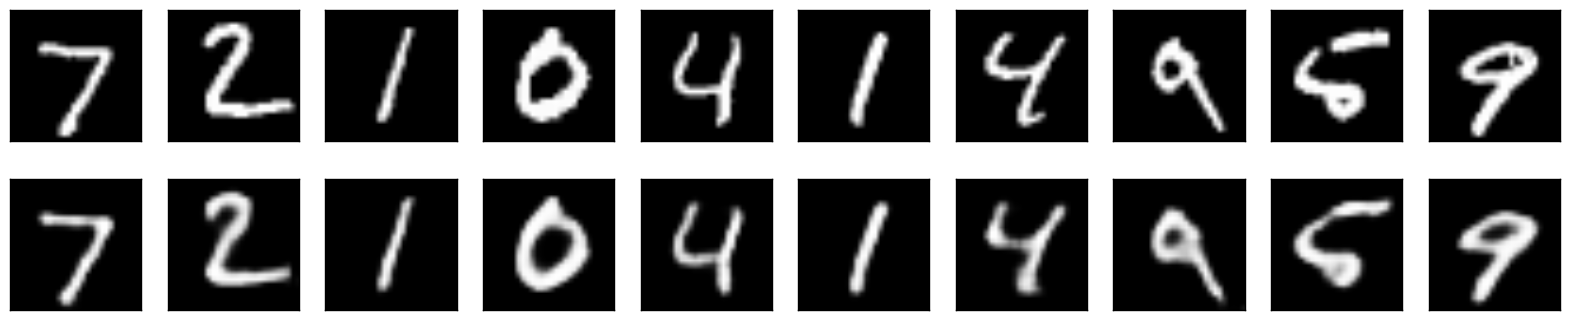

In [55]:
decoded_imgs = autoencoder.predict(X_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n +1 )
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

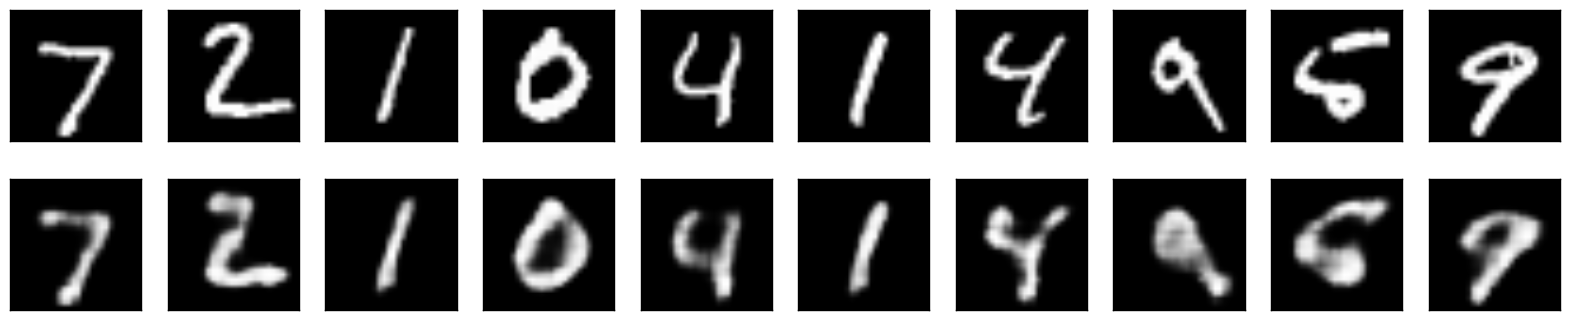

In [85]:
decoded_imgs = model.predict(X_test)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n +1 )
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### DFN auto-encoder

In [82]:
# Works on fixed batch size as of now
model = Sequential()
model.add(InputLayer(batch_input_shape=(batch_size, 1, img_rows, img_cols)))
model.add(PPDFN(7))
model.add(Activation('relu'))
model.add(Convolution2D(16, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D((2, 2), border_mode='same'))
model.add(Convolution2D(8, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D((2, 2), border_mode='same'))
model.add(Convolution2D(8, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D((2, 2), border_mode='same'))
model.add(Convolution2D(8, 3, 3, activation='relu', border_mode='same'))
model.add(UpSampling2D((2, 2)))
model.add(Convolution2D(8, 3, 3, activation='relu', border_mode='same'))
model.add(UpSampling2D((2, 2)))
model.add(Convolution2D(16, 3, 3, activation='relu'))
model.add(UpSampling2D((2, 2)))
model.add(Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same'))
model.compile(optimizer='adam', loss='binary_crossentropy')

In [83]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_23 (InputLayer)            (1024, 1, 28, 28)     0                                            
____________________________________________________________________________________________________
ppdfn_27 (PPDFN)                 (1024, 1, 28, 28)     1499        input_23[0][0]                   
____________________________________________________________________________________________________
activation_18 (Activation)       (1024, 1, 28, 28)     0           ppdfn_27[0][0]                   
____________________________________________________________________________________________________
convolution2d_100 (Convolution2D)(1024, 16, 28, 28)    160         activation_18[0][0]              
___________________________________________________________________________________________

In [84]:
model.fit(X_train, X_train,
                nb_epoch=20,
                batch_size=2048,
                shuffle=True,
                validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 21s - loss: 0.5194 - val_loss: 0.4117
Epoch 2/20
60000/60000 [==============================] - 21s - loss: 0.3220 - val_loss: 0.2497
Epoch 3/20
60000/60000 [==============================] - 21s - loss: 0.2299 - val_loss: 0.2149
Epoch 4/20
60000/60000 [==============================] - 21s - loss: 0.2063 - val_loss: 0.1981
Epoch 5/20
60000/60000 [==============================] - 22s - loss: 0.1913 - val_loss: 0.1844
Epoch 6/20
60000/60000 [==============================] - 21s - loss: 0.1798 - val_loss: 0.1741
Epoch 7/20
60000/60000 [==============================] - 21s - loss: 0.1710 - val_loss: 0.1662
Epoch 8/20
60000/60000 [==============================] - 21s - loss: 0.1642 - val_loss: 0.1601
Epoch 9/20
60000/60000 [==============================] - 21s - loss: 0.1588 - val_loss: 0.1550
Epoch 10/20
60000/60000 [==============================] - 22s - loss: 0.1543 - val_lo

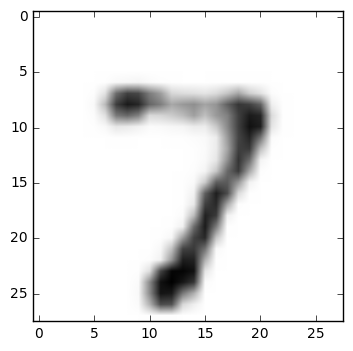

In [86]:
plt.imshow(decoded_imgs[0, 0], cmap="Greys")

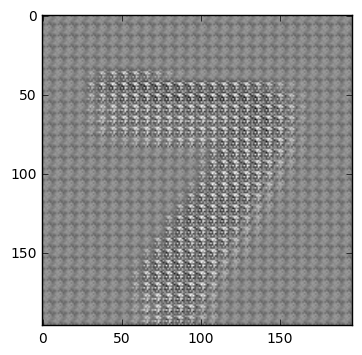

In [87]:
get_filter = get_filter_getter(model)
fs = get_filter(X_test[:20])
plt.imshow(filters_image(fs[0]))

In [51]:
gen = model.layers[1].gen
a = gen.coordinates_weights.get_value()

In [52]:
gen.coordinates.eval()[0, 0]

array([[-1.46687257, -1.99878156, -1.47023892, -0.00562654, -0.26125073,
        -1.46154678, -1.93342435, -1.46938038,  0.03133357, -0.27354863,
        -1.45782709, -1.86868143, -1.47022164,  0.06816409, -0.28500938,
        -1.45589375, -1.80462193, -1.47295356,  0.10485051, -0.29553899,
        -1.45594442, -1.74132156, -1.47778535,  0.14137688, -0.30503446,
        -1.45819366, -1.67886233, -1.48494411],
       [ 0.17772591, -0.31338388, -1.46287096, -1.61733186, -1.49467289,
         0.21387909, -0.32046771, -1.47021806, -1.55682278, -1.5072273 ,
         0.24981686, -0.32615986, -1.48048306, -1.49742997, -1.52287006,
         0.28551927, -0.33033112, -1.49391377, -1.43924832, -1.54186344,
         0.32096627, -0.33285215, -1.51074874, -1.38236904, -1.56445992,
         0.35613871, -0.33359873, -1.53120625],
       [-1.32687545, -1.59089041,  0.3910189 , -0.33245715, -1.55547237,
        -1.27283895, -1.62135208,  0.42559183, -0.32933024, -1.58369029,
        -1.22031438, -1.6559